# Lesson 2 : LangGraph Components

In [1]:
# !brew install graphviz
# export C_INCLUDE_PATH=$(brew --prefix graphviz)/include
# export LIBRARY_PATH=$(brew --prefix graphviz)/lib
# pip install pygraphviz

# get free Tavily key at https://app.tavily.com/sign-in and put in .env

In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

In [36]:
import os
from typing import TypedDict, Annotated
import operator
from IPython.display import Image, display, HTML, Markdown

import requests

import openai

from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langchain_core.pydantic_v1 import BaseModel, Field

import wikipedia


import openbb
from openbb import obb


In [4]:
MODEL='gpt-4o'

DOWNLOAD_DIR = 'download'
OUTPUT_Dir = 'output'


# Basic LangChain prompt completion


In [34]:
model = ChatOpenAI(model=MODEL)

messages = [
    SystemMessage(content="Translate the following from English into French"),
    HumanMessage(content="Listen to me. You are beautiful. You are flawless and I love you."),
]

response = model.invoke(messages)

print(response.content)


Écoute-moi. Tu es belle. Tu es parfaite et je t'aime.


# With a prompt template


In [10]:
system_template = "Translate the following into {language}:"
user_template = "Listen to me. You are {adjective1}. You are {adjective2} and I love you."

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), 
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

# stream tokens as they are generated
response = ""
for r in chain.stream({"language": "German", "adjective1": "tops", "adjective2": "amazing"}):
    print(r, end="")
    response += r

# response


Hör mir zu. Du bist spitze. Du bist erstaunlich und ich liebe dich.

# Using a graph and a tool

In [11]:
mytool = TavilySearchResults(max_results=4) #increased number of results
print(type(mytool))
print(mytool.name)


<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [12]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
        

In [13]:
memory = AsyncSqliteSaver.from_conn_string(":memory:")

class Agent:

    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Sending tool results back to the model!")
        return {'messages': results}


In [14]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You can make multiple calls (either simultaneously or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model=MODEL)
lg_agent = Agent(model, [mytool], memory, system=prompt)


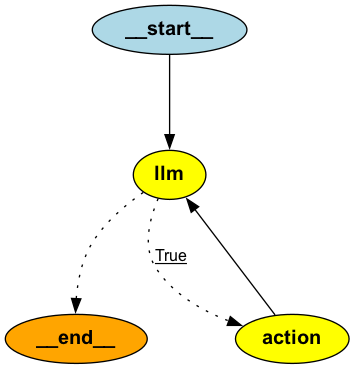

In [15]:
Image(lg_agent.graph.get_graph().draw_png())


In [16]:
messages = [HumanMessage(content="What is the current weather in Brooklyn and as of what time?")]
thread = {"configurable": {"thread_id": "1"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":  # stream content
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown("**Final result**"))

display(Markdown(all_content))


/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Brooklyn'}, 'id': 'call_UVcUjyEA5fRgnEMn8NDhJqYC'}
Sending tool results back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Brooklyn, NY'}, 'id': 'call_70Xilc7ivMuLGrKDlcJkHW9n'}
Sending tool results back to the model!
The current weather in Brooklyn, NY as of 1:30 PM on June 24, 2024, is 25.6°C (78.1°F) and overcast. The wind is coming from the west-northwest at 2.2 mph (3.6 kph). The humidity is at 42%, and visibility is 16 km (9 miles). The UV index is 7.

**Final result**

The current weather in Brooklyn, NY as of 1:30 PM on June 24, 2024, is 25.6°C (78.1°F) and overcast. The wind is coming from the west-northwest at 2.2 mph (3.6 kph). The humidity is at 42%, and visibility is 16 km (9 miles). The UV index is 7.

# Using 2 tools in parallel

In [18]:
messages = [HumanMessage(content="What is the weather in San Francisco, Eureka, and Denver? and as of what time")]
thread = {"configurable": {"thread_id": "2"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown(all_content))


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_zlYP80w8gPtcGmo2st8lEqZK'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Eureka, California'}, 'id': 'call_k4jqShchNQJ1YI2TQGHs8EHp'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Denver, Colorado'}, 'id': 'call_QCIANLQzsE0TkhUdT951ez4R'}
Sending tool results back to the model!
### San Francisco
- **Current Temperature**: 17.2°C (63.0°F)
- **Condition**: Partly cloudy
- **Wind**: 11.9 mph (19.1 kph) from the NW
- **Humidity**: 67%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 10:30 AM local time

### Eureka, California
- **Current Temperature**: 13.3°C (55.9°F)
- **Condition**: Overcast
- **Wind**: 3.8 mph (6.1 kph) from the W
- **Humidity**: 77%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 10:30 AM local time

### Denver, Colorado
- **Curr

### San Francisco
- **Current Temperature**: 17.2°C (63.0°F)
- **Condition**: Partly cloudy
- **Wind**: 11.9 mph (19.1 kph) from the NW
- **Humidity**: 67%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 10:30 AM local time

### Eureka, California
- **Current Temperature**: 13.3°C (55.9°F)
- **Condition**: Overcast
- **Wind**: 3.8 mph (6.1 kph) from the W
- **Humidity**: 77%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 10:30 AM local time

### Denver, Colorado
- **Current Temperature**: 32.7°C (90.9°F)
- **Condition**: Partly cloudy
- **Wind**: 2.2 mph (3.6 kph) from the N
- **Humidity**: 13%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 11:30 AM local time

# 2 or more tools in sequence, where answer from 2nd depends on result from 1st

In [19]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
Who are the statewide elected officials of that state? Answer each question." 
messages = [HumanMessage(content=query)]
thread = {"configurable": {"thread_id": "3"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown(all_content))


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_BGFfSkZ8sqpAxdcVAK8XW7o5'}
Sending tool results back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_iUcpFmFPHcBZqtXVhvhP3s1Q'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current statewide elected officials of Missouri'}, 'id': 'call_S2BnaNcs4mqtxScwELkxJLfx'}
Sending tool results back to the model!
### Who won the Super Bowl in 2024?
The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers in overtime with a score of 25-22.

### In what state is the winning team headquarters located?
The Kansas City Chiefs are headquartered in Kansas City, Missouri. Their address is One Arrowhead Drive, Kansas City, MO 64129, USA.

### Who are the statewide elected officials of that state?
The statewide elected officials of Missouri include:

1. **Governor**: 

### Who won the Super Bowl in 2024?
The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers in overtime with a score of 25-22.

### In what state is the winning team headquarters located?
The Kansas City Chiefs are headquartered in Kansas City, Missouri. Their address is One Arrowhead Drive, Kansas City, MO 64129, USA.

### Who are the statewide elected officials of that state?
The statewide elected officials of Missouri include:

1. **Governor**: Mike Parson
2. **Lieutenant Governor**: Mike Kehoe
3. **Secretary of State**: Jay Ashcroft
4. **Attorney General**: Andrew Bailey
5. **State Treasurer**: Vivek Malek
6. **State Auditor**: Scott Fitzpatrick

Additionally, Missouri's U.S. Senators are:
- Eric Schmitt
- Josh Hawley

These details are accurate as of the most recent updates.

# Summarize a Wikipedia page


In [20]:
def delete_files(download_dir):
    """
    Deletes non-hidden files in the specified directory.

    Args:
        download_dir (str): The path to the directory containing the files.

    Raises:
        OSError: If there is an error while deleting a file.

    Note:
        This function does not delete subdirectories. If you want to remove subdirectories as well, use os.rmdir().

    Example:
        >>> delete_files('/path/to/directory')
    """

    # Iterate over all files in the directory
    for filename in os.listdir(download_dir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(download_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

delete_files(DOWNLOAD_DIR)


In [98]:
def fn_perplexity_profile(symbol, company):
    """Return a company profile from Perplexity"""
    
    perplexity_url = "https://api.perplexity.ai/chat/completions"
    # https://docs.perplexity.ai/docs/model-cards
    perplexity_model = 'llama-3-70b-instruct'

    system_prompt = """
You will act as a securities analyst and investment advisor with deep knowledge of financial markets, 
securities analysis, portfolio management. You will maintain a professional yet engaging tone, 
in the style of a senior investment bank research analyst."
"""

    user_prompt = f"""You will focus on {company} ({symbol}), and provide a comprehensive analysis 
covering the following topics:

Company Profile: An overview of {company}, including its history, commercial operations and sales 
by lines of business and geography, and recent key developments.

Recent Events: Significant recent news events related to {company} or its industry impacting its stock.

Financial Performance: Recent earnings reports and stock performance compared to expectations, 
changes in dividends or stock buybacks.

Analyst Coverage: Summarize recent changes to analysts' ratings noting which analyst and firm 
made upgrades or downgrades on which date; summarize any recent short seller reports noting the 
firm and analyst.

Product Announcements: Launch of new products, strategic initiatives, or restructurings.

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures, 
joint ventures, and major new business and revenue.

Securities Offerings: Announcements related to stock or bond issuances, buybacks, special 
dividends, or stock splits.

Management Changes: Significant personnel changes within {company}.

Stock Price Movements: Stock price trends and notable deviations from trend and reasons for them.
"""

    payload = {
        "model": perplexity_model,
        "messages": [
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": user_prompt,
            }
        ]
    }

    perplexity_headers = {
        "Authorization": f"Bearer {os.getenv('PERPLEXITY_API_KEY')}",
        "accept": "application/json",
        "content-type": "application/json"
    }

    response = requests.post(perplexity_url, json=payload, headers=perplexity_headers)
    if response.status_code == 200:
        response_str = response.json()['choices'][0]['message']['content']
        response_str = response_str.replace("$", "\\\$")
        with open(f"{DOWNLOAD_DIR}/profile_px.txt", "w") as outfile:
            outfile.write(response_str)
    else:
        response_str = response.content
    return response_str


profile_px = fn_perplexity_profile(symbol, company)

display(Markdown(profile_px))


**Tesla, Inc. (TSLA) - Comprehensive Analysis**

**Company Profile:**

Tesla, Inc. is a pioneering electric vehicle (EV) manufacturer and clean energy company founded in 2003 by Elon Musk, JB Straubel, Martin Eberhard, and Marc Tarpenning. Headquartered in Palo Alto, California, Tesla has disrupted the automotive industry with its innovative electric vehicles, energy storage systems, and solar panel manufacturing. The company operates through two main segments: Automotive and Energy Generation & Storage.

Tesla's commercial operations span across the globe, with a strong presence in North America, Europe, and Asia. The company has expanded its product lineup to include the Model S, Model X, Model 3, Model Y, Cybertruck, Semi, and Roadster. Tesla's energy storage products, including the Powerwall and Powerpack, have gained significant traction in the residential and commercial markets.

**Recent Events:**

* Tesla's Q4 2022 earnings report exceeded expectations, driven by strong demand for its electric vehicles and energy storage products.
* The company announced plans to invest \\$3.6 billion in its Nevada Gigafactory to increase production capacity and reduce costs.
* Tesla's market value surpassed \\$1 trillion, solidifying its position as one of the most valuable companies in the world.
* The company faced intense competition from traditional automakers, such as General Motors and Ford, which have accelerated their EV production plans.
* Tesla's Autopilot technology has been under scrutiny following a series of accidents and regulatory probes.

**Financial Performance:**

* Q4 2022 Earnings Report: Tesla reported revenue of \\$24.3 billion, beating estimates of \\$22.4 billion. Adjusted EPS came in at \\$1.19, exceeding expectations of \\$1.13.
* Stock Performance: Tesla's stock has rallied over 50% in the past six months, driven by strong earnings and increasing demand for EVs.
* Dividend and Buyback: Tesla has not paid dividends since its IPO and has not announced any share buyback programs.

**Analyst Coverage:**

* Upgrades:
	+ Goldman Sachs (February 2023): Upgraded to "Buy" from "Neutral" with a price target of \\$1,200.
	+ Morgan Stanley (January 2023): Upgraded to "Overweight" from "Equal-weight" with a price target of \\$1,100.
* Downgrades:
	+ JPMorgan (December 2022): Downgraded to "Neutral" from "Overweight" with a price target of \\$950.
	+ Credit Suisse (November 2022): Downgraded to "Neutral" from "Outperform" with a price target of \\$900.
* Short Seller Reports:
	+ Citron Research (February 2023): Maintained a short position, citing concerns over Tesla's valuation and competition from traditional automakers.

**Product Announcements:**

* Tesla unveiled its Cybertruck in November 2022, which has received over 250,000 pre-orders.
* The company launched its Model Y crossover SUV in March 2022, which has become a top-seller in the EV market.
* Tesla announced plans to launch a new electric vehicle platform, which will enable faster production and lower costs.

**Strategic Initiatives:**

* Tesla partnered with Hertz to supply 100,000 electric vehicles to the rental car company.
* The company acquired a 10% stake in the Australian energy company, Neoen, to expand its energy storage business.
* Tesla announced plans to build a new factory in Mexico, which will produce electric vehicles and energy storage products.

**Securities Offerings:**

* Tesla issued \\$2.7 billion in convertible senior notes in September 2022 to fund its growth initiatives.
* The company did not announce any stock buybacks or special dividends in the past quarter.

**Management Changes:**

* Tesla appointed a new Chief Financial Officer, Zach Kirkhorn, in January 2023, replacing Deepak Ahuja.
* The company's Chief Operating Officer, Jerome Guillen, left the company in June 2022.

**Stock Price Movements:**

* Tesla's stock price has trended upward over the past six months, driven by strong earnings and increasing demand for EVs.
* The stock experienced a notable deviation from trend in November 2022, following a fatal accident involving a Tesla vehicle, which led to a 10% decline in the stock price.
* The stock has since recovered, driven by the company's strong Q4 2022 earnings report and increasing optimism around the EV industry.

Overall, Tesla's strong financial performance, innovative products, and strategic initiatives have driven its stock price higher. However, the company faces intense competition from traditional automakers and regulatory probes, which may impact its stock price in the future.

In [27]:
# get a list of wikipedia suggestions for a query using the wikipedia module

symbol = 'TSLA'
company = 'Tesla'

def fn_get_wikipedia_suggestions(symbol, company):
    """search for possible Wikipedia pages for a ticker symbol"""
    query_str = f'{company} ({symbol})'
    search_results = wikipedia.search(query_str)
    return search_results
        
search_results = fn_get_wikipedia_suggestions(symbol, company)
search_results


['Tesla, Inc.',
 "Elon Musk's Tesla Roadster",
 'Tesla Powerwall',
 'History of Tesla, Inc.',
 'Tesla Semi',
 'Tesla Model 3',
 'TSLA',
 'Tesla Autopilot',
 'Tesla Fremont Factory',
 'Tesla Model X']

In [81]:
# use LLM to pick the best page for symbol and company from search_results

def fn_pick_wiki_page(model, symbol, company, search_results):
    """Given a company, ticker, and a list of wikipedia pages search_results, return the most likely wikipedia page matching the given company and symbol"""

    system_template = """You will act as a Wikipedia page selection helper. 
    I will provide a description of a company I am writing a profile of, and a list of
    search results of possible Wikipedia pages to use formatted as a Python array. 
    Your task is to select the most relevant Wikipedia page from the search results to 
    help write a profile of the company."""

    user_template = """Given the following Wikipedia search results for the company 
    named {company} (ticker {symbol}), select the most likely main Wikipedia page for {company} 
    and return it as a JSON object with a single field named title:

    Search Results: 
    {search_results}
    """

    # use openai json response type
    wikititle_structured_model = model.with_structured_output(Wiki_title, method="json_mode")

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_template),
         ("user", user_template)]
    )

    chain = prompt_template | wikititle_structured_model 
    response_obj = chain.invoke({"company": company,
                                 "symbol": symbol,
                                 "search_results": search_results},
                            )
    print(response_obj.title, flush=True)
    return response_obj.title

page = fn_pick_wiki_page(model, "TSLA", "Tesla", search_results)
page 

Tesla, Inc.


'Tesla, Inc.'

In [25]:
# fetch the wikipedia page

def fn_get_wiki_page(page):
    """Given the name of existing wikipedia page, return the content of the page"""
    return wikipedia.page(title=page, auto_suggest=False).content

page_content = fn_get_wiki_page(page)
page_content[:1000]

"Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company's name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company's largest shareholder; in 2008, he was named chief executive officer. In 2008, the company began production of its first car model, the Roadster sports car, followed by the Model S sedan in 2012, the Model X SUV in 2015, the Model 3 sedan in 2017, the Model Y crossover in 2020, the Tesla Semi truck in 2022 and the Cybertruck pickup truck in 2023. The Model

In [28]:
# use the LLM to summarize the page based on a prompt, and save it to a file
def summarize_wiki_page(model, symbol, company, content):
    """Given the content of the company's wikipedia page, summarize the content of the page"""

    system_prompt = """You will act as a securities analyst with deep knowledge of financial markets, 
securities analysis, and portfolio management. You will maintain a professional yet engaging tone, 
in the style of a senior investment bank research analyst. You will provide facts
relevant to investors and avoid opinions unless specifically requested.
    """

    user_prompt = f"""You will focus on {company} ({symbol}). You will summarize the provided content below from
Wikipedia for {company} and summarize all topics of interest to investors on this page in 3000 
words or less, in particular the following topics:

Company Profile: An overview of {company}, including its history, commercial operations and sales 
by lines of business and geography, and recent key developments.

Products and services: {company} offerings, their features and benefits, target markets, recent 
changes such as launches and discontinuations of products and services. 

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures, 
joint ventures, strategic initiatives, restructurings, and any other major developments.

Recent Events: Significant recent news events, management changes, controversies 
and other developments related to {company} or its industry which might impact its stock.

Use only the provided content below:
{content}
"""

    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    prompt_template = ChatPromptTemplate.from_messages(messages)

    parser = StrOutputParser()

    chain = prompt_template | model | parser

    response_str = ""    
    for r in chain.stream(dict(symbol=symbol, company=company, page_content=page_content)):
        print(r, end="", flush=True)
        response_str += r

    outfile_name = "wiki_summary.txt"            
    with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
        outfile.write(response_str)
    return response_str

page_summary = summarize_wiki_page(model, symbol, company, page_content)
display(Markdown(page_summary))


### Company Profile

#### Overview and History
Tesla, Inc. (TSLA) is an American multinational automotive and clean energy company headquartered in Austin, Texas. Founded in July 2003 by Martin Eberhard and Marc Tarpenning, the company designs, manufactures, and sells battery electric vehicles (BEVs), energy storage devices, solar panels, solar shingles, and related products and services. Tesla’s name is a tribute to inventor Nikola Tesla. Elon Musk joined the company as the largest shareholder in 2004 and became CEO in 2008. Tesla began production with the Roadster sports car in 2008, followed by models such as the Model S sedan (2012), Model X SUV (2015), Model 3 sedan (2017), Model Y crossover (2020), Tesla Semi truck (2022), and Cybertruck (2023).

#### Market Position and Financial Milestones
Tesla is one of the world’s most valuable companies by market capitalization. It became a trillion-dollar company in October 2021, the seventh U.S. company to achieve this milestone. By 2023,

### Company Profile

#### Overview and History
Tesla, Inc. (TSLA) is an American multinational automotive and clean energy company headquartered in Austin, Texas. Founded in July 2003 by Martin Eberhard and Marc Tarpenning, the company designs, manufactures, and sells battery electric vehicles (BEVs), energy storage devices, solar panels, solar shingles, and related products and services. Tesla’s name is a tribute to inventor Nikola Tesla. Elon Musk joined the company as the largest shareholder in 2004 and became CEO in 2008. Tesla began production with the Roadster sports car in 2008, followed by models such as the Model S sedan (2012), Model X SUV (2015), Model 3 sedan (2017), Model Y crossover (2020), Tesla Semi truck (2022), and Cybertruck (2023).

#### Market Position and Financial Milestones
Tesla is one of the world’s most valuable companies by market capitalization. It became a trillion-dollar company in October 2021, the seventh U.S. company to achieve this milestone. By 2023, Tesla led the BEV market with a 19.9% share and was ranked 69th in the Forbes Global 2000. As of March 2024, it remains the world’s most valuable automaker. The company's stock has faced fluctuations due to various controversies, lawsuits, and Musk's statements, impacting investor confidence.

### Products and Services

#### Vehicle Models
Tesla's current vehicle lineup includes the Model S, Model X, Model 3, Model Y, Tesla Semi, and Cybertruck. Each model is designed to cater to different market segments, from luxury sedans and SUVs to mass-market vehicles and commercial trucks.

1. **Model S**: A full-size luxury car with dual motor all-wheel drive, known for its high performance and long-range capabilities. It has undergone two major design refreshes.
2. **Model X**: A mid-size luxury crossover SUV with unique falcon-wing doors, available in configurations for 5 to 7 passengers.
3. **Model 3**: A more affordable mid-size car with a fastback body style, available in all-wheel and rear-wheel drive layouts. It became the world’s bestselling electric car from 2018 to 2021.
4. **Model Y**: A mid-size crossover SUV designed to be more affordable than the Model X, available in 5- and 7-passenger configurations. It became the world’s bestselling car in Q1 2023.
5. **Tesla Semi**: A Class 8 semi-truck with a tri-motor, rear-wheel drive layout, boasting a range of 500 miles. Full production is expected by 2025.
6. **Cybertruck**: A full-sized pickup truck with a distinctive stainless steel exterior. Deliveries began in November 2023.

#### Energy Products
Tesla Energy, formed from the merger with SolarCity, offers solar energy generation systems and battery storage products like the Powerwall (for homes) and Megapack (for large-scale energy storage). In 2023, Tesla deployed 14.7 GWh of battery energy storage products.

#### Connectivity and Services
Tesla vehicles come with "Standard Connectivity" for basic navigation and "Premium Connectivity" for enhanced features like live traffic updates and media streaming. The company provides remote diagnostics and mobile servicing, aiming not to profit from vehicle servicing.

#### Charging Infrastructure
Tesla operates the Supercharger network for fast charging and the Destination Charging network for slower, location-specific charging. The company has also ventured into vehicle insurance, offering personalized pricing based on driving safety scores.

### Strategic Initiatives

#### Business Strategy
Tesla's strategy involves producing high-price, low-volume vehicles to reduce battery costs, enabling the production of more affordable, higher-volume cars. Tesla uses a direct-sales model, avoiding traditional dealerships, and maintains high vertical integration, developing many components in-house.

#### Partnerships and Acquisitions
Tesla has formed significant partnerships, notably with Panasonic for battery production. It has also signed long-term lithium supply contracts. In 2024, Tesla secured a deal with Tata Electronics for semiconductor chips, marking its expansion into the Indian market.

### Recent Events

#### Key Developments
1. **Gigafactories**: Tesla expanded production with new Gigafactories in Shanghai, Berlin, Texas, and plans for a Gigafactory in Mexico. These facilities boost production capacity and international market reach.
2. **Bitcoin Investment**: Tesla invested $1.5 billion in Bitcoin in early 2021 but ceased accepting it as payment due to environmental concerns. By July 2022, Tesla sold about 75% of its Bitcoin holdings.
3. **Charging Standard**: Between May 2023 and February 2024, major North American EV manufacturers announced plans to adopt Tesla’s North American Charging Standard, which is expected to provide recurring revenue.

#### Controversies and Legal Issues
Tesla has faced various lawsuits and controversies, including allegations of workplace harassment, labor disputes, and product defects. The company also faced scrutiny over Musk’s social media statements, leading to a $20 million fine and Musk stepping down as chairman temporarily.

#### Management Changes
In April 2024, Tesla announced the layoff of 10% of its employees. Additionally, Tesla moved its legal headquarters to Texas in December 2021 but expanded its operations in California, including a new global engineering headquarters in Palo Alto.

### Conclusion

Tesla remains a dominant player in the electric vehicle and clean energy markets, with significant investments in technology, production facilities, and strategic partnerships. Despite facing legal and operational challenges, the company continues to innovate and expand globally, maintaining a strong market position and investor interest.

In [119]:

def fn_get_obb_profile(symbol):

    obb_results = obb.equity.profile(symbol=symbol)
    profile_openbb = obb_results.results[0].long_description

    with open(f"{DOWNLOAD_DIR}/profile_openbb.txt", "w") as outfile:
        outfile.write(profile_openbb)
        
    return profile_openbb
    
print(fn_get_obb_profile(symbol))


Tesla, Inc. engages in the design, development, manufacture, and sale of electric vehicles and energy generation and storage systems. The company operates through Automotive and Energy Generation and Storage. The Automotive segment includes the design, development, manufacture, sale, and lease of electric vehicles as well as sales of automotive regulatory credits. The Energy Generation and Storage segment is involved in the design, manufacture, installation, sale, and lease of stationary energy storage products and solar energy systems, and sale of solar energy systems incentives. The company was founded by Jeffrey B. Straubel, Elon Reeve Musk, Martin Eberhard, and Marc Tarpenning on July 1, 2003 and is headquartered in Austin, TX.


In [120]:
# a class to maintain the current state of the graph

class TearsheetState(TypedDict):
    
    company: str
    symbol: str
    wiki_search_results: str
    wiki_page_title: str
    wiki_page_text: str
    wiki_page_summary: str
    perplexity_profile: str
    obb_profile: str
    error_state: str

# a Pydantic class to get a structured object back from an LLM query

class Wiki_title(BaseModel):
    title: str = Field(description="The title of the main Wikipedia page for a company")


In [126]:
# use a graph to run all the components.
# class will contain the graph, the model, and tools, and have nodes for the functions above

class TearsheetAgent:

    def __init__(self, model, tools, checkpointer):
        graph = StateGraph(TearsheetState)

        graph.add_node("get_wiki_page_suggestions", self.get_wikipedia_suggestions)
        graph.add_node("pick_wiki_page", self.pick_wiki_page)
        graph.add_node("get_wiki_page", self.get_wiki_page)
        graph.add_node("summarize_wiki_page", self.summarize_wiki_page)
        graph.add_node("get_perplexity_profile", self.get_perplexity_profile)
        graph.add_node("get_openbb_profile", self.get_openbb_profile)

        graph.set_entry_point("get_wiki_page_suggestions")
        graph.add_edge("get_wiki_page_suggestions", "pick_wiki_page")
        graph.add_edge("pick_wiki_page", "get_wiki_page")
        graph.add_edge("get_wiki_page", "summarize_wiki_page")
        graph.add_edge("summarize_wiki_page", "get_perplexity_profile")
        graph.add_edge("get_perplexity_profile", "get_openbb_profile")
        graph.set_finish_point("get_openbb_profile")
        
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        self.model = model
    

    def get_wikipedia_suggestions(self, state):
        """search for possible Wikipedia pages for a ticker symbol"""
        search_results = fn_get_wikipedia_suggestions(state["symbol"], state["company"])
        state["wiki_search_results"] = search_results
        return state
    

    def pick_wiki_page(self, state):
        """Given a company, ticker, and a list of wikipedia pages search_results, return the most likely wikipedia page matching the given company and symbol"""
        state["wiki_page_title"] = fn_pick_wiki_page(self.model,
                                                     state["symbol"],
                                                     state["company"],
                                                     state["wiki_search_results"]
                                                    )
        return state
    
    
    def get_wiki_page(self, state):
        """Given the name of existing wikipedia page, return the content of the page"""
        state["wiki_page_text"] = fn_get_wiki_page(state["wiki_page_title"])
        
        return state
    

    def summarize_wiki_page(self, state):
        """Given the content of the company's wikipedia page, summarize the content of the page"""

        state["wiki_page_summary"] = summarize_wiki_page(self.model, 
                                                         state["symbol"], 
                                                         state["company"], 
                                                         state["wiki_page_text"])

        return state
    
    
    def get_perplexity_profile(self, state):
        """Return a summary company profile from Perplexity"""
        state["perplexity_profile"] = fn_perplexity_profile(state["symbol"],
                                                            state["company"])
        

    def get_openbb_profile(self, state):
        """Return a summary company profile from Perplexity"""
        state["obb_profile"] = fn_get_obb_profile(state["symbol"])
        

    def run(self, config, state):

        for step in self.graph.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                print(step["step"], step["payload"].get("values"))

            # Check if there is an error message in the state
            if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
                # Update the error state to 'tested' since error simulation is complete
                state['error_state'] = 'tested'
                # Retry from the last checkpoint saved by the checkpointer
                for retry_step in graph.stream(state, config, stream_mode="debug"):
                    if retry_step["type"] == "checkpoint":
                        print(retry_step["step"], retry_step["payload"].get("values"))
                break
        return None
       

In [127]:
model = ChatOpenAI(model=MODEL)
memory = SqliteSaver.from_conn_string(":memory:")

lg_agent = TearsheetAgent(model, [], memory)


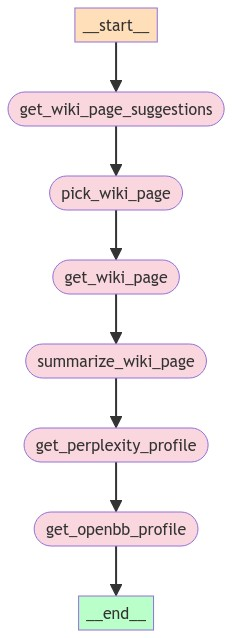

In [128]:
Image(lg_agent.graph.get_graph().draw_mermaid_png())

In [129]:
# Configuration with thread ID for checkpointing
config = {"configurable": {"thread_id": "profile-thread-1"}}
# initial state
state = WikiAgentState(company="Tesla", symbol="TSLA")
lg_agent.run(config, state)


-1 {}
0 {'company': 'Tesla', 'symbol': 'TSLA'}
1 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'Tesla Powerwall', 'History of Tesla, Inc.', 'Tesla Model 3', 'Tesla Fremont Factory', 'Tesla Semi', 'TSLA', 'Tesla Model S', 'Tesla Model X'], 'wiki_page_title': None, 'wiki_page_text': None, 'wiki_page_summary': None, 'perplexity_profile': None, 'obb_profile': None, 'error_state': None}
Tesla, Inc.
2 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'Tesla Powerwall', 'History of Tesla, Inc.', 'Tesla Model 3', 'Tesla Fremont Factory', 'Tesla Semi', 'TSLA', 'Tesla Model S', 'Tesla Model X'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': None, 'wiki_page_summary': None, 'perplexity_profile': None, 'obb_profile': None, 'error_state': None}
3 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'Tesla Powerwall', 'Hi

### Company Profile

**Overview and History**

Tesla, Inc., headquartered in Austin, Texas, is a leading American multinational in the automotive and clean energy sectors. The company specializes in designing, manufacturing, and selling battery electric vehicles (BEVs), stationary battery energy storage devices, solar panels, solar shingles, and associated products and services. Tesla is also exploring artificial intelligence and robotics.

Founded in July 2003 by Martin Eberhard and Marc Tarpenning, Tesla was initially named Tesla Motors, a tribute to inventor Nikola Tesla. Elon Musk joined as the largest shareholder in 2004 and became CEO in 2008. The company's first vehicle, the Roadster sports car, launched in 2008, followed by the Model S sedan in 2012, Model X SUV in 2015, Model 3 sedan in 2017, Model Y crossover in 2020, Tesla Semi truck in 2022, and Cybertruck pickup truck in 2023.

**Market Position**

Tesla is one of the world's most valuable companies by market capitalizatio

5 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'Tesla Powerwall', 'History of Tesla, Inc.', 'Tesla Model 3', 'Tesla Fremont Factory', 'Tesla Semi', 'TSLA', 'Tesla Model S', 'Tesla Model X'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': 'Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company\'s name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company\'s largest shareholder; in 2008, he was named chief

In [113]:
with open(f"{DOWNLOAD_DIR}/wiki_summary.txt", "r") as infile:
    display(Markdown(infile.read()))

### Company Profile

**Overview:**  
Tesla, Inc., founded in 2003 by Martin Eberhard and Marc Tarpenning and headquartered in Austin, Texas, is a leading automotive and clean energy company. Tesla designs, manufactures, and sells battery electric vehicles (BEVs), stationary battery energy storage devices, solar panels, and related products and services. The company is also venturing into artificial intelligence and robotics.

**History and Evolution:**  
Incorporated as Tesla Motors in July 2003, the company aimed to be both a car manufacturer and a technology firm. Elon Musk joined as the largest shareholder in 2004 and became CEO in 2008. Tesla's first vehicle, the Roadster, was launched in 2008. Subsequent models include the Model S (2012), Model X (2015), Model 3 (2017), Model Y (2020), Tesla Semi (2022), and Cybertruck (2023). The Model 3 is the world's all-time best-selling plug-in electric car, and the Model Y became the best-selling vehicle worldwide in 2023.

**Market Leadership:**  
Tesla is one of the world's most valuable companies by market capitalization, briefly becoming a trillion-dollar company in October 2021. It leads the battery electric vehicle market with a 19.9% share as of 2023 and is ranked 69th in the Forbes Global 2000. Tesla is also the world's most valuable automaker.

**Legal and Regulatory Challenges:**  
Tesla has faced numerous lawsuits and government scrutiny related to whistleblower retaliation, worker rights, safety issues, product defects, and CEO Musk's controversial statements.

### Products and Services

**Vehicle Models:**
1. **Model S:** A full-size luxury liftback with all-wheel drive. Released in 2012, the Model S has undergone significant design refreshes in 2016 and 2021.
2. **Model X:** A mid-size luxury crossover SUV with unique "falcon-wing" rear doors. Available since 2015, it shares about 30% of its parts with the Model S.
3. **Model 3:** A mid-size fastback, more affordable than the Model S, introduced in 2017. It has become the world's best-selling electric car multiple years in a row.
4. **Model Y:** A mid-size crossover SUV designed for affordability, launched in 2020. It shares about 75% of its parts with the Model 3 and became the world's best-selling car in Q1 2023.
5. **Tesla Semi:** A Class 8 semi-truck with a tri-motor setup, launched in 2022. Full production is expected in 2025.
6. **Cybertruck:** A full-sized pickup truck with a distinctive stainless steel exterior, deliveries started in November 2023.

**Energy Products:**  
Tesla Energy offers solar panels, the Tesla Solar Roof, and storage solutions like the Powerwall for homes and the Megapack for large-scale energy storage. Tesla Energy reported a 125% increase in battery energy storage deployment in 2023.

**Connectivity and Charging Services:**
- **Supercharger Network:** High-voltage direct current fast chargers.
- **Destination Chargers:** Slower chargers installed at hotels, restaurants, and shopping centers.
- **Insurance Services:** Tesla offers personalized vehicle insurance in several U.S. states, leveraging data from its vehicles.

### Strategic Initiatives

**Expansion and Factories:**  
Tesla has aggressively expanded its production capabilities with new Gigafactories in Shanghai (2019), Berlin-Brandenburg (2022), and Texas (2022). It plans to open Gigafactory Mexico by 2025. The company also established a new global engineering headquarters in Palo Alto in 2023.

**Partnerships and Acquisitions:**
- **SolarCity Merger (2016):** Tesla acquired SolarCity and merged it with its battery energy storage division to form Tesla Energy.
- **Partnerships:** Long-term deals with battery suppliers like CATL, LG Energy Solution, and Panasonic. Plans to switch to Tesla's North American Charging Standard adapters by 2025 with other North American EV manufacturers.
- **Acquisitions:** Purchased Grohmann Engineering, Maxwell Technologies, Hibar Systems, and Springpower International for technology and manufacturing capabilities.

**Research and Development:**
- **Battery Technology:** Tesla uses four battery cell types: 18650, 2170, 4680, and prismatic. The company invests heavily in in-house battery production and research partnerships.
- **Software and Autopilot:** Tesla's vehicles use over-the-air updates for features and fixes. It continues to develop its Full Self-Driving (FSD) capabilities, although regulatory and safety concerns remain.

### Recent Events

**Management Changes and Controversies:**
- **Elon Musk's Leadership:** Continues to be a focal point of both innovation and controversy. He faced SEC sanctions for misleading statements about taking Tesla private.
- **Workplace Issues:** Tesla has been sued for sexual harassment, racial discrimination, and labor law violations.
- **Environmental Concerns:** The company has faced penalties for hazardous waste violations and environmental permit issues.

**Financial Performance:**
- **Bitcoin Investment:** Tesla invested $1.5 billion in Bitcoin in 2021 but later sold about 75% of its holdings due to profitability concerns.
- **Revenue and Profitability:** Reported significant growth in 2021, with $5.52 billion in net income and $53.8 billion in revenue. Regulatory credits and Bitcoin investments have been notable contributors.

**Technological Developments:**
- **FSD in China:** Tesla's Full Self-Driving software was approved in China in April 2024.
- **Next-Generation Vehicle Platform:** Announced but not expected before 2025.

**Market Dynamics:**
- **Layoffs:** Announced a 10% workforce reduction in April 2024.
- **Charging Infrastructure:** Nearly all major North American EV manufacturers plan to adopt Tesla's charging standards by 2025.

### Conclusion

Tesla remains a dynamic and influential player in both the automotive and clean energy sectors. While the company continues to face legal and regulatory challenges, its strategic initiatives and technological innovations position it well for future growth. Tesla's aggressive expansion, innovative products, and market leadership make it a critical company to watch for investors interested in the EV and clean energy markets.

In [114]:
with open(f"{DOWNLOAD_DIR}/profile_px.txt", "r") as infile:
    display(Markdown(infile.read()))
    

**Tesla, Inc. (TSLA) - Comprehensive Analysis**

**Company Profile:**
Tesla, Inc. is a pioneering electric vehicle (EV) manufacturer and clean energy company founded in 2003 by Elon Musk, JB Straubel, Martin Eberhard, and Marc Tarpenning. Headquartered in Palo Alto, California, Tesla has disrupted the automotive industry with its innovative electric vehicles, energy storage systems, and solar panel manufacturing. The company operates through two main segments: Automotive and Energy Generation & Storage.

**Commercial Operations and Sales:**
Tesla's automotive segment generates the majority of its revenue, with sales of electric vehicles, including the Model S, Model 3, Model X, Model Y, and the upcoming Cybertruck. The company has expanded its presence globally, with a strong presence in the United States, China, Norway, and other European countries. In addition to vehicle sales, Tesla also generates revenue from its energy storage products, including the Powerwall and Powerpack, as well as its solar panel business.

**Recent Key Developments:**
In recent years, Tesla has made significant strides in expanding its production capacity, improving manufacturing efficiency, and investing in autonomous driving technology. The company has also made notable progress in its energy business, including the acquisition of SolarCity in 2016.

**Recent Events:**

* On October 23, 2022, Tesla reported its Q3 2022 earnings, beating analysts' expectations with a net income of \\$1.05 billion, driven by strong vehicle sales and improved margins.
* On November 1, 2022, Tesla announced plans to invest \\$3.6 billion in its Nevada Gigafactory, expanding its battery production capacity.
* On December 1, 2022, Elon Musk announced his intention to step down as CEO of Twitter, sparking speculation about his potential return to a more active role at Tesla.

**Financial Performance:**
Tesla's stock has been volatile in recent months, driven by concerns over production and delivery challenges, as well as global economic uncertainty. Despite these challenges, the company has reported strong earnings growth, with Q3 2022 net income increasing 103% year-over-year.

**Earnings Reports:**

* Q3 2022: EPS \\$1.05, beating estimates of \\$0.94
* Q2 2022: EPS \\$0.93, beating estimates of \\$0.83
* Q1 2022: EPS \\$0.80, missing estimates of \\$0.85

**Analyst Coverage:**

* On November 15, 2022, Morgan Stanley analyst Adam Jonas upgraded Tesla to "Overweight" from "Equal Weight," citing improving margins and strong demand for electric vehicles.
* On October 25, 2022, Goldman Sachs analyst Mark Delaney downgraded Tesla to "Neutral" from "Buy," citing concerns over production and delivery challenges.
* On September 20, 2022, short seller firm, Hindenburg Research, published a report highlighting concerns over Tesla's accounting practices and Autopilot technology.

**Product Announcements:**

* On November 10, 2022, Tesla announced the launch of its Full Self-Driving (FSD) beta software, marking a significant milestone in its autonomous driving technology development.
* On October 15, 2022, Tesla unveiled its new Cybertruck, a futuristic electric pickup truck with a starting price of \\$39,900.

**Strategic Initiatives:**

* On December 15, 2022, Tesla announced a partnership with Hertz to supply up to 100,000 electric vehicles to the rental car company.
* On November 20, 2022, Tesla signed a deal with Panasonic to expand its battery production capacity at the Gigafactory in Nevada.

**Securities Offerings:**

* On September 10, 2022, Tesla announced a \\$2.7 billion stock offering to raise capital for its expansion plans.

**Management Changes:**

* On November 1, 2022, Tesla announced the appointment of Jerome Guillen as its new President of Automotive, replacing Drew Baglino.

**Stock Price Movements:**
Tesla's stock has been highly volatile in recent months, driven by a combination of factors, including earnings reports, production and delivery challenges, and global economic uncertainty. The stock has trended downward since its peak in November 2021, with notable deviations from trend in response to earnings reports and product announcements.

Overall, Tesla remains a leader in the electric vehicle market, with a strong brand and growing presence globally. While the company faces challenges in the near term, its long-term prospects remain promising, driven by its innovative products, expanding production capacity, and growing demand for clean energy solutions.

In [130]:
with open(f"{DOWNLOAD_DIR}/profile_openbb.txt", "r") as infile:
    display(Markdown(infile.read()))
    

Tesla, Inc. engages in the design, development, manufacture, and sale of electric vehicles and energy generation and storage systems. The company operates through Automotive and Energy Generation and Storage. The Automotive segment includes the design, development, manufacture, sale, and lease of electric vehicles as well as sales of automotive regulatory credits. The Energy Generation and Storage segment is involved in the design, manufacture, installation, sale, and lease of stationary energy storage products and solar energy systems, and sale of solar energy systems incentives. The company was founded by Jeffrey B. Straubel, Elon Reeve Musk, Martin Eberhard, and Marc Tarpenning on July 1, 2003 and is headquartered in Austin, TX.

In [ ]:
review tearsheet.ipynb
10k

get_finviz_news
other top news

chart

other obb stuff


# growth metrics
# valuation metrics
# technicals

# compare to market and to peers

# competitors etc., top etfs, review obb stuff
# analyst updates

# get better top news
# get better analyst updates
# review obb for other stuff to include.

# review tearsheet newsapi newsfilter etc.
# scrape tearsheet sites
# twitter

# chart 
# profile


# growth metrics
# valuation metrics
# technicals

# compare to market and to peers
f